In [1]:
!pip install feedparser

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.6 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6046 sha256=d31e4e8fcadfb0b93c1a24f51c0d79e46f7cd2768796844f95a08d84a8d83836
  Stored in directory: /root/.cache/pip/wheels/3b/25/2a/105d6a15df6914f4d15047691c6c28f9052cc1173e40285d03
Successfully built sgmllib3k


## **Pipeline pour le scrapping des document sur arxiv**
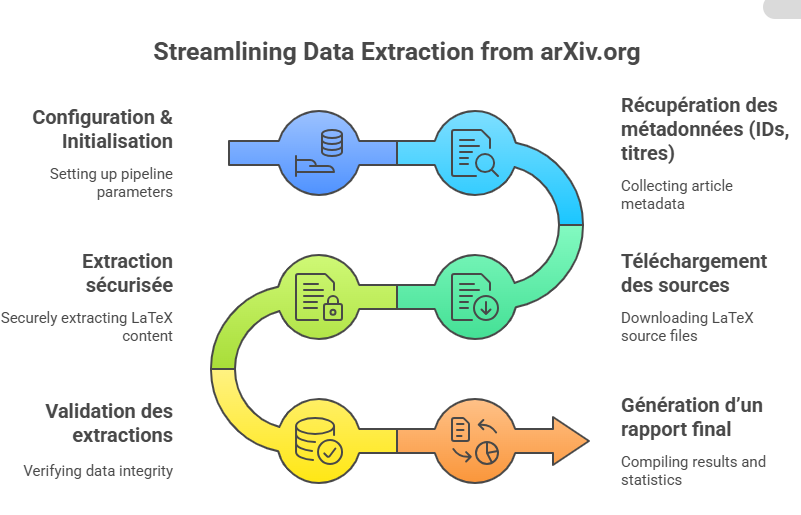

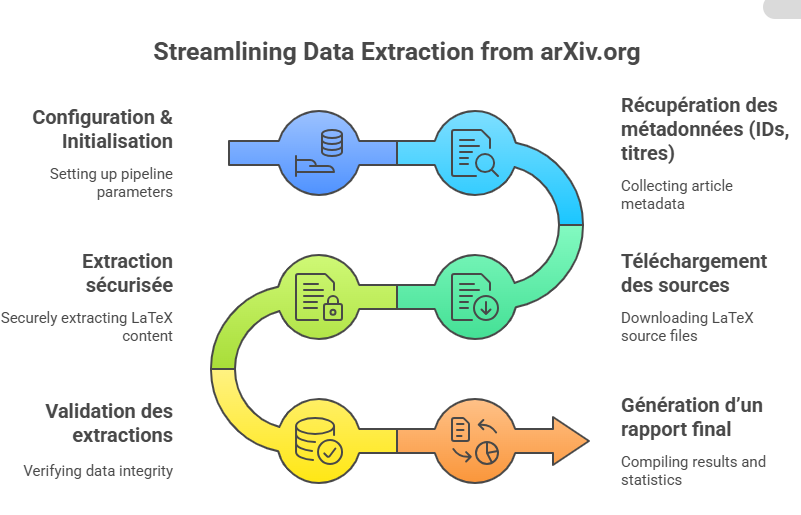

In [2]:
# --- Imports des bibliothèques nécessaires ---
import json
import logging
import shutil
import tarfile
import time
import urllib.parse
from contextlib import contextmanager
from dataclasses import dataclass
from datetime import datetime
from pathlib import Path
from typing import Dict, Iterator, List

import feedparser
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
from tqdm.notebook import tqdm # Important pour un affichage correct dans les notebooks

# --- Configuration du Logging ---
# Le logger est configuré pour écrire dans un fichier dans /kaggle/working/ 
# et afficher les messages dans la sortie de la cellule.
log_file = Path("/kaggle/working/arxiv_scraper.log")
if log_file.exists():
    log_file.unlink() # Supprime l'ancien log au redémarrage

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(log_file, mode='w', encoding='utf-8'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger("ArxivScraper")

In [4]:
# --- Configuration via Dataclass ---
# Centralise tous les paramètres pour une meilleure lisibilité et maintenance.
@dataclass(frozen=True)
class ScraperConfig:
    """Configuration immuable pour le scraper ArXiv."""
    base_dir: Path
    categories: List[str]
    max_results_per_category: int
    api_url: str = "http://export.arxiv.org/api/query"
    download_url_template: str = "https://arxiv.org/e-print/{arxiv_id}"
    delay_between_requests: float = 3.0  # Seconds, to respect ArXiv's policies
    request_timeout: int = 45 # Increased timeout for potentially slow connections
    max_retries: int = 3

# --- PARAMÈTRES MODIFIABLES ---
# Modifiez ces valeurs selon vos besoins.
CATEGORIES_TO_SCRAPE = [
    "cs.LG",      # Machine Learning
    "cs.AI",      # Artificial Intelligence
    "cs.CV",      # Computer Vision
    "cs.CL",      # Computation and Language
    "stat.ML",    # Machine Learning (Statistics)
]

MAX_RESULTS = 200
# Le répertoire de sortie dans l'environnement Kaggle
OUTPUT_DIRECTORY = Path("/kaggle/working/arxiv_data")

# --- Instanciation de la configuration ---
CONFIG = ScraperConfig(
    base_dir=OUTPUT_DIRECTORY,
    categories=CATEGORIES_TO_SCRAPE,
    max_results_per_category=MAX_RESULTS
)

logger.info(f"Configuration chargée : {CONFIG.max_results_per_category} articles par catégorie dans {CONFIG.base_dir}")

In [5]:
# --- Gestionnaire de contexte pour les fichiers temporaires ---
@contextmanager
def temporary_extraction_dir(parent_dir: Path, dirname: str) -> Iterator[Path]:
    """Crée, fournit et nettoie un répertoire d'extraction temporaire."""
    temp_dir = parent_dir / f".tmp_{dirname}"
    temp_dir.mkdir(parents=True, exist_ok=True)
    try:
        yield temp_dir
    finally:
        try:
            shutil.rmtree(temp_dir)
        except OSError as e:
            logger.error(f"Erreur lors du nettoyage de {temp_dir}: {e}")


# --- Classe Principale du Scraper ---
class ArxivScraper:
    """
    Scrape, télécharge et extrait les sources d'articles depuis ArXiv
    de manière robuste et configurable.
    """

    def __init__(self, config: ScraperConfig):
        self.config = config
        self.stats = {
            'total_articles_found': 0, 'successful_downloads': 0,
            'failed_downloads': 0, 'skipped_existing': 0,
            'categories_processed': 0, 'api_errors': 0
        }
        self.start_time = datetime.now()
        self.session = self._create_http_session()
        self.config.base_dir.mkdir(parents=True, exist_ok=True)

    def _create_http_session(self) -> requests.Session:
        """Crée une session requests résiliente avec une politique de re-tentative."""
        session = requests.Session()
        session.headers.update({'User-Agent': 'KaggleNotebookScraper/1.0'})
        retries = Retry(
            total=self.config.max_retries, backoff_factor=1,
            status_forcelist=[500, 502, 503, 504],
        )
        adapter = HTTPAdapter(max_retries=retries)
        session.mount('http://', adapter)
        session.mount('https://', adapter)
        return session

    def fetch_articles_metadata(self, category: str) -> List[Dict]:
        """Récupère les métadonnées des articles pour une catégorie donnée."""
        # ... (le contenu de cette méthode et des autres est identique à la version précédente)
        # Pour la lisibilité, je ne la recopie pas entièrement ici, mais vous devez la mettre.
        # Assurez-vous d'inclure les méthodes :
        # fetch_articles_metadata
        # _is_extraction_valid
        # download_and_extract_source
        # process_category
        # run
        # print_final_report
        #
        # Voici la version complète à copier-coller pour cette cellule :
        query_params = {
            'search_query': f'cat:{category}', 'start': 0,
            'max_results': self.config.max_results_per_category,
            'sortBy': 'submittedDate', 'sortOrder': 'descending'
        }
        url = f"{self.config.api_url}?{urllib.parse.urlencode(query_params)}"
        logger.debug(f"Requête API : {url}")
        try:
            feed = feedparser.parse(url)
            if feed.bozo: raise feed.bozo_exception
            if not feed.entries:
                logger.warning(f"Aucun article trouvé pour la catégorie '{category}'.")
                return []
            
            articles = [{
                'id': entry.id.split('/')[-1].split('v')[0],
                'title': entry.get('title', 'Sans titre').replace('\n', ' ').strip(),
                'summary': entry.get('summary', 'Pas de résumé.'),
                'published': entry.get('published_parsed')
            } for entry in feed.entries]

            logger.info(f"✅ {len(articles)} articles trouvés pour '{category}'.")
            return articles
        except Exception as e:
            logger.error(f"❌ Erreur API pour '{category}': {e}")
            self.stats['api_errors'] += 1
            return []

    def _is_extraction_valid(self, extract_dir: Path) -> bool:
        """Vérifie si un répertoire d'extraction contient des fichiers pertinents."""
        if not extract_dir.is_dir(): return False
        useful_extensions = {'.tex', '.py', '.md', '.txt', '.bib', '.pdf'}
        return any(f.is_file() and f.suffix.lower() in useful_extensions for f in extract_dir.rglob('*'))

    def download_and_extract_source(self, article: Dict, category_dir: Path) -> bool:
        """Télécharge, extrait et valide les sources d'un article."""
        arxiv_id = article['id']
        final_extract_dir = category_dir / arxiv_id
        download_url = self.config.download_url_template.format(arxiv_id=arxiv_id)

        try:
            with temporary_extraction_dir(category_dir, arxiv_id) as temp_dir:
                tar_path = temp_dir / f"{arxiv_id}.tar.gz"
                response = self.session.get(download_url, stream=True, timeout=self.config.request_timeout)
                response.raise_for_status()
                with open(tar_path, "wb") as f: shutil.copyfileobj(response.raw, f)

                temp_extract_subdir = temp_dir / "extracted"
                temp_extract_subdir.mkdir()
                try:
                    with tarfile.open(tar_path, "r:gz") as tar:
                        def is_within_directory(directory, target):
                            abs_directory = directory.resolve()
                            abs_target = target.resolve()
                            return abs_directory in abs_target.parents
                        
                        safe_members = [m for m in tar.getmembers() if is_within_directory(temp_extract_subdir, temp_extract_subdir / m.name)]
                        tar.extractall(path=temp_extract_subdir, members=safe_members)
                except tarfile.ReadError:
                    logger.warning(f"⚠️ {arxiv_id} n'est pas une archive tar.gz, copie simple.")
                    shutil.copy2(tar_path, temp_extract_subdir / f"{arxiv_id}.tex")

                if not self._is_extraction_valid(temp_extract_subdir):
                    logger.error(f"❌ Validation échouée pour {arxiv_id}: contenu non pertinent.")
                    return False
                
                metadata_path = temp_extract_subdir / 'metadata.json'
                with open(metadata_path, 'w', encoding='utf-8') as f:
                    json.dump(article, f, indent=2, default=str)

                shutil.move(str(temp_extract_subdir), str(final_extract_dir))
                return True
        except requests.exceptions.HTTPError as e:
            if e.response.status_code in [403, 404]: logger.warning(f"⚠️ Source non disponible pour {arxiv_id} (code: {e.response.status_code}).")
            else: logger.error(f"❌ Erreur HTTP pour {arxiv_id}: {e}")
            return False
        except requests.exceptions.RequestException as e:
            logger.error(f"❌ Erreur réseau pour {arxiv_id}: {e}")
            return False
        except Exception as e:
            logger.error(f"❌ Erreur inattendue pour {arxiv_id}: {e}", exc_info=False)
            return False

    def process_category(self, category: str):
        """Traite tous les articles d'une catégorie."""
        logger.info(f"\n--- 📚 Traitement de la catégorie : {category} ---")
        category_dir = self.config.base_dir / category.replace('.', '_')
        category_dir.mkdir(exist_ok=True)
        articles = self.fetch_articles_metadata(category)
        if not articles: return

        self.stats['total_articles_found'] += len(articles)
        for article in tqdm(articles, desc=f"📖 {category}", unit=" article", leave=False):
            extract_dir = category_dir / article['id']
            if extract_dir.exists() and self._is_extraction_valid(extract_dir):
                self.stats['skipped_existing'] += 1
            else:
                success = self.download_and_extract_source(article, category_dir)
                self.stats['successful_downloads' if success else 'failed_downloads'] += 1
                time.sleep(self.config.delay_between_requests)
    
    def run(self):
        """Lance le processus complet de scraping."""
        logger.info("🚀 Démarrage du scraper ArXiv...")
        for category in tqdm(self.config.categories, desc="🗂️  Catégories", unit="cat"):
            self.process_category(category)
            self.stats['categories_processed'] += 1
        logger.info("✨ Scraping terminé!")

    def print_final_report(self):
        """Affiche un rapport final détaillé sur les opérations."""
        duration = datetime.now() - self.start_time
        report_lines = [
            "\n" + "="*70, "📊 RAPPORT FINAL", "="*70,
            f"⏱️  Durée totale: {str(duration).split('.')[0]}",
            f"📁 Catégories traitées: {self.stats['categories_processed']}/{len(self.config.categories)}",
            f"📄 Total articles trouvés: {self.stats['total_articles_found']}",
            f"✅ Téléchargements réussis: {self.stats['successful_downloads']}",
            f"⏭️  Articles ignorés (déjà présents): {self.stats['skipped_existing']}",
            f"❌ Téléchargements échoués: {self.stats['failed_downloads']}",
            f"🔌 Erreurs API: {self.stats['api_errors']}",
        ]
        total_processed = self.stats['successful_downloads'] + self.stats['failed_downloads']
        if total_processed > 0:
            success_rate = (self.stats['successful_downloads'] / total_processed) * 100
            report_lines.append(f"📈 Taux de réussite (téléchargements): {success_rate:.1f}%")
        if self.stats['total_articles_found'] > 0:
            coverage = (self.stats['successful_downloads'] + self.stats['skipped_existing']) / self.stats['total_articles_found'] * 100
            report_lines.append(f"🎯 Couverture des articles trouvés: {coverage:.1f}%")
        report_lines.append("="*70)
        logger.info("\n".join(report_lines))

In [6]:
# --- Point d'entrée pour l'exécution ---
scraper = ArxivScraper(CONFIG)

try:
    scraper.run()
except KeyboardInterrupt:
    logger.warning("\n⚠️ Interruption par l'utilisateur. Affichage du rapport partiel.")
except Exception as e:
    logger.critical(f"❌ Erreur fatale non interceptée : {e}", exc_info=True)
finally:
    scraper.print_final_report()
    logger.info(f"Les données sont sauvegardées dans : {CONFIG.base_dir}")
    logger.info(f"Le journal détaillé se trouve dans : {log_file}")

🗂️  Catégories:   0%|          | 0/5 [00:00<?, ?cat/s]

📖 cs.LG:   0%|          | 0/200 [00:00<?, ? article/s]

📖 cs.AI:   0%|          | 0/200 [00:00<?, ? article/s]

📖 cs.CV:   0%|          | 0/200 [00:00<?, ? article/s]

## **Generation de description a partie des codes latex , des meta data et de l'API Gemini**

In [7]:
import json
import logging
import re
import time
from dataclasses import dataclass, asdict
from pathlib import Path
from typing import List, Dict, Any, Optional

import google.generativeai as genai
from PIL import Image, UnidentifiedImageError
from tqdm.notebook import tqdm
from kaggle_secrets import UserSecretsClient

# --- Configuration du Logging ---
log_file = Path("/kaggle/working/gemini_pipeline.log")
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(log_file, mode='w', encoding='utf-8'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger("GeminiPipeline")

In [ ]:
# --- Configuration et Initialisation de l'API ---

# Récupération sécurisée de la clé API
try:
    
    GEMINI_API_KEY = UserSecretsClient().get_secret("GEMINI_API_KEY")
    genai.configure(api_key=GEMINI_API_KEY)
    logger.info("✅ Clé API Gemini configurée avec succès depuis Kaggle Secrets.")
except Exception as e:
    logger.error("❌ Impossible de récupérer la clé API Gemini. Assurez-vous de l'avoir ajoutée dans 'Add-ons -> Secrets' sous le nom 'GEMINI_API_KEY'.")
    GEMINI_API_KEY = None


@dataclass(frozen=True)
class PipelineConfig:
    """Configuration de la pipeline de génération de dataset."""
    input_dir: Path
    output_file: Path
    gemini_model_name: str = "gemini-1.5-flash-latest"  # Modèle multimodal rapide et efficace
    api_delay_seconds: float = 2.0  # Pour respecter les limites de l'API (60 RPM par défaut)
    max_retries: int = 3
    # Ignorer les fichiers .tex de moins de N caractères
    min_tex_file_size: int = 250


# --- Paramètres modifiables ---
INPUT_DIR = Path("/kaggle/working/arxiv_data")
OUTPUT_FILE = Path("/kaggle/working/latex_description_dataset.jsonl")

# --- Instanciation de la configuration ---
CONFIG = PipelineConfig(
    input_dir=INPUT_DIR,
    output_file=OUTPUT_FILE,
)

# Supprimer le fichier de sortie s'il existe pour une exécution propre
if CONFIG.output_file.exists():
    CONFIG.output_file.unlink()

In [33]:
# --- IMPORTS ET CONFIGURATIONS PRÉALABLES (non modifiés) ---
import json
import logging
import re
import time
from dataclasses import dataclass, asdict
from pathlib import Path
from typing import List, Dict, Any, Optional

import google.generativeai as genai
from PIL import Image, UnidentifiedImageError
from tqdm.notebook import tqdm
# Assumez que les classes/variables suivantes sont définies dans les cellules précédentes :
# PipelineConfig, logger, GEMINI_API_KEY


# --- CLASSE CORRIGÉE ---

@dataclass
class GeneratedRecord:
    """Structure pour une entrée du nouveau dataset."""
    source_file: str  # Chemin relatif du fichier .tex
    description: str
    code_latex: str

class LatexToDescriptionPipeline:
    """
    Pipeline pour générer des descriptions de code LaTeX en utilisant Gemini.
    """
    def __init__(self, config: PipelineConfig):
        self.config = config
        self.model = genai.GenerativeModel(config.gemini_model_name)
        self.image_pattern = re.compile(r'\\includegraphics(?:\[.*\])?\{(.+?)\}')

    def _find_referenced_images(self, tex_content: str, article_dir: Path) -> List[Image.Image]:
        """Trouve, charge et retourne les images référencées dans le code LaTeX."""
        image_filenames = self.image_pattern.findall(tex_content)
        loaded_images = []
        
        for filename in image_filenames:
            possible_paths = [
                article_dir / filename,
                article_dir / f"{filename}.png",
                article_dir / f"{filename}.jpg",
                article_dir / f"{filename}.jpeg",
                article_dir / f"{filename}.pdf",
                article_dir / f"{filename}.eps",
            ]
            
            for path in possible_paths:
                if path.exists():
                    try:
                        if path.suffix.lower() in ['.png', '.jpg', '.jpeg', '.bmp', '.gif']:
                           img = Image.open(path)
                           loaded_images.append(img)
                           logger.debug(f"Image chargée : {path.name}")
                        else:
                            logger.info(f"Format d'image non directement supporté trouvé (non envoyé à l'API) : {path.name}")
                    except UnidentifiedImageError:
                        logger.warning(f"PIL n'a pas pu identifier le fichier image : {path}")
                    except Exception as e:
                        logger.error(f"Erreur lors du chargement de l'image {path}: {e}")
                    break
        return loaded_images

    def _build_prompt(self, tex_content: str, images: List[Image.Image]) -> List[Any]:
        """Construit la requête multimodale pour Gemini."""
        # CORRECTION 1: Utilisation d'une "raw string" (r""") pour éviter les erreurs d'échappement
        prompt_text = r"""
Vous êtes un expert en LaTeX et en documentation technique. Votre mission est de créer une description textuelle détaillée qui permettrait à un modèle d'IA de reconstruire le code LaTeX fourni, y compris la structure, le formatage et le contenu.

**INSTRUCTIONS CLÉS :**
1.  **Décrivez la structure, pas seulement le contenu** : Ne vous contentez pas de résumer le texte. Décrivez les commandes LaTeX utilisées.
2.  **Préambule** : Listez la `documentclass` et tous les packages (`\usepackage`).
3.  **Structure du document** : Décrivez chaque section, sous-section, etc. en mentionnant la commande (`\section{...}`).
4.  **Formatage** : Mentionnez explicitement les commandes de formatage comme `\textbf{...}`, `\textit{...}`, `\texttt{...}`.
5.  **Environnements** : Pour les environnements (`figure`, `table`, `equation`, `itemize`, `enumerate`), décrivez-les précisément. Mentionnez leur contenu, leurs légendes (`\caption`), et leurs labels (`\label`).
6.  **Images** : Pour chaque image fournie, je la décris dans le prompte par [IMAGE X]. Décrivez le contenu de l'image et comment elle est incluse (`\includegraphics`).
7.  **Citations et Références** : Notez l'utilisation des commandes `\cite{...}` et `\ref{...}` avec leurs clés.
8.  **Sortie** : Votre sortie doit être **UNIQUEMENT** la description textuelle, sans aucun préambule comme "Voici la description :".

**EXEMPLE DE DESCRIPTION SOUHAITÉE :**
"Le document commence avec la classe 'article' en 12pt. Il utilise les packages 'graphicx' et 'amsmath'. Le titre est 'Exemple de Document' et l'auteur est 'John Doe'. Le document contient une section intitulée 'Introduction'. Cette section contient un paragraphe de texte et une référence au label 'fig:diagram'. Une figure flottante est incluse, centrée, avec le label 'fig:diagram'. Elle contient l'image [IMAGE 1] qui est un diagramme de flux de données. La légende de la figure est 'Diagramme de flux'. Ensuite, une équation est affichée en utilisant l'environnement 'equation'..."

---
**CONTENU À DÉCRIRE :**
"""
        
        prompt_parts = [prompt_text]
        
        original_tex = tex_content
        
        for i, img in enumerate(images):
            image_marker = f"[IMAGE {i+1}]"
            # Remplace la première occurrence de \includegraphics par le marqueur
            original_tex = self.image_pattern.sub(image_marker, original_tex, count=1)
            prompt_parts.append(img)

        prompt_parts.append("\n--- CODE LATEX ---\n" + original_tex)
        
        # CORRECTION 2: Suppression du fragment de code incorrect. La méthode retourne bien `prompt_parts`.
        return prompt_parts

    def _call_gemini_api(self, prompt_parts: List[Any]) -> Optional[str]:
        """Appelle l'API Gemini avec une gestion des erreurs et des tentatives."""
        for attempt in range(self.config.max_retries):
            try:
                response = self.model.generate_content(prompt_parts)
                return response.text
            except Exception as e:
                logger.warning(f"Tentative {attempt + 1} a échoué : {e}")
                if attempt < self.config.max_retries - 1:
                    time.sleep(self.config.api_delay_seconds * (attempt + 1))
        
        logger.error("Toutes les tentatives pour appeler l'API Gemini ont échoué.")
        return None

    def run(self):
        """Lance la pipeline complète."""
        if not GEMINI_API_KEY:
            logger.critical("Arrêt de la pipeline car la clé API Gemini n'est pas disponible.")
            return

        logger.info(f"🚀 Démarrage de la pipeline. Recherche des fichiers .tex dans {self.config.input_dir}")
        tex_files = list(self.config.input_dir.rglob('*.tex'))
        logger.info(f"Trouvé {len(tex_files)} fichiers .tex au total.")
        
        processed_count = 0
        with tqdm(total=len(tex_files), desc="Processing .tex files") as pbar:
            for tex_path in tex_files:
                pbar.update(1)
                try:
                    if tex_path.stat().st_size < self.config.min_tex_file_size:
                        logger.debug(f"Fichier ignoré (trop petit) : {tex_path.name}")
                        continue
                        
                    article_dir = tex_path.parent
                    latex_content = tex_path.read_text(encoding='utf-8', errors='ignore')
                    
                    images = self._find_referenced_images(latex_content, article_dir)
                    prompt = self._build_prompt(latex_content, images)
                    
                    logger.info(f"Génération de la description pour : {tex_path.relative_to(self.config.input_dir)}")
                    description = self._call_gemini_api(prompt)
                    
                    if description:
                        # Note : Le `latex_content` original (sans les marqueurs [IMAGE]) est sauvegardé.
                        record = GeneratedRecord(
                            source_file=str(tex_path.relative_to(self.config.input_dir)),
                            description=description.strip(),
                            code_latex=latex_content
                        )
                        
                        with open(self.config.output_file, "a", encoding="utf-8") as f:
                            f.write(json.dumps(asdict(record)) + "\n")
                        processed_count += 1
                    else:
                        logger.error(f"Échec de la génération de la description pour {tex_path.name}")

                    time.sleep(self.config.api_delay_seconds)

                except Exception as e:
                    logger.error(f"Erreur fatale lors du traitement du fichier {tex_path}: {e}", exc_info=True)
                    
        logger.info("=" * 70)
        logger.info("✅ PIPELINE TERMINÉE")
        logger.info(f"📄 {processed_count} descriptions ont été générées avec succès.")
        logger.info(f"💾 Dataset sauvegardé dans : {self.config.output_file}")
        logger.info("=" * 70)

In [ ]:
# --- Point d'entrée pour l'exécution ---
if not CONFIG.input_dir.exists():
    logger.error(f"Le répertoire d'entrée '{CONFIG.input_dir}' n'existe pas. Assurez-vous d'avoir exécuté le scraper avant.")
else:
    pipeline = LatexToDescriptionPipeline(CONFIG)
    try:
        pipeline.run()
    except KeyboardInterrupt:
        logger.info("\n⚠️ Interruption par l'utilisateur. Le travail déjà sauvegardé est conservé.")
    except Exception as e:
        logger.critical(f"❌ Erreur fatale non interceptée dans la pipeline : {e}", exc_info=True)

Processing .tex files:   0%|          | 0/1942 [00:00<?, ?it/s]